# Enoncé: 
    
Nous allons implémenter une architecture auto encoder et découvrir ensemble l'un des cas d'applications. Nous allons à l'aide d'un autoencoder débruité des images.
L'objectif est d'entrainer un autoencoder à reproduire l'entrée qu'il a.
Comme nous diminuons l'information au centre de l'autoencoder, seul les informations les plus pertinentes sont conservées.
Celles-ci sont séléctionnées automatiquement par apprentissage. En effet, en essayant d'optimiser notre fonction de coût, l'autoencoder va, pour mimnimiser son erreur, conserver uniquement l'information qui a le plus d'impact sur la sortie.

Une fois que notre autoencoder est entraîné, on peut le réutiliser en lui donnant en entrée une image bruitée. L'autoencoder va ainsi nous retourner une image sans bruit.

Pour ce tp nous utiliserons les images du challenge mnist 

Vous devrez remplacer les "?" par le code. Appuyez vous sur la documentation keras

# 1.Import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
import keras

from keras.models import Model
from keras.datasets import mnist
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Input, UpSampling2D

from keras.models import Sequential
print(keras.__version__)

Using TensorFlow backend.


2.3.1


# 2. Load dataset

In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

In [4]:
#observez les shape de x_train et x_test
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [5]:
def print_images(dataset, is_reshape=False):
    for i in range (10):
        item = random.randrange(0, dataset.shape[0], dataset.shape[0]/10)
        if is_reshape:
            img = dataset[item].reshape(28,28)
        else:
            img = dataset[item]
        plt.imshow(img, interpolation='nearest')
        plt.show()

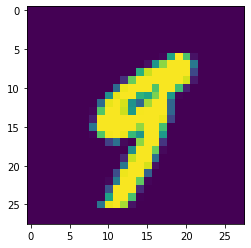

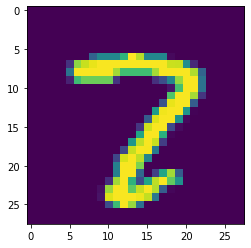

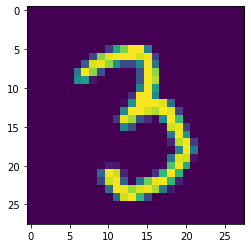

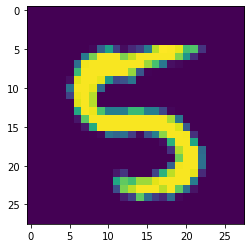

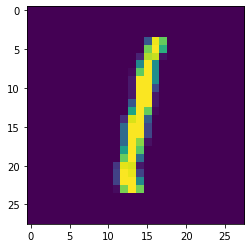

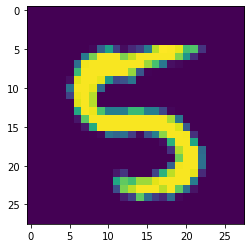

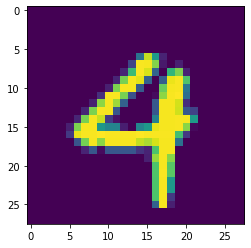

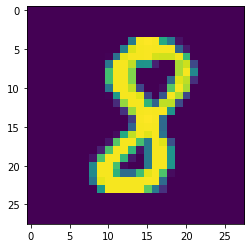

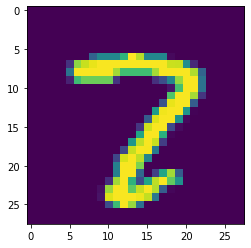

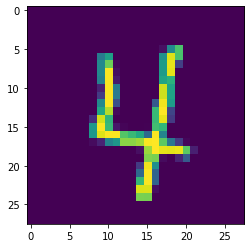

In [6]:
print_images(x_train)

## 2.1 Normalise data

In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
# normalize train data
x_train = x_train.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
print(x_train.shape)

(60000, 28, 28, 1)


In [9]:
# normalize test data (which serves as our labels)
x_test = x_test.astype('float32') / 255
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_test.shape)

(10000, 28, 28, 1)


## 2.2 Add noise

In [10]:
# create noisy data for train and test
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

In [11]:
# renormalize through clipping
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

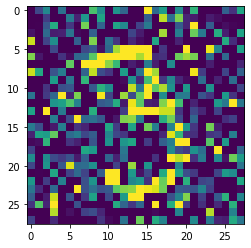

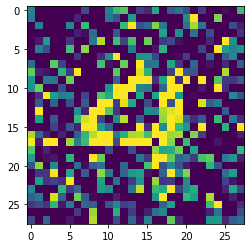

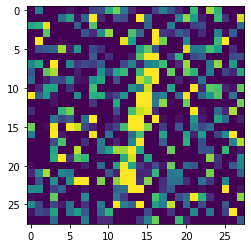

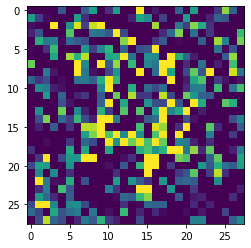

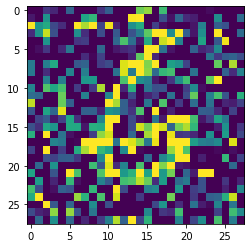

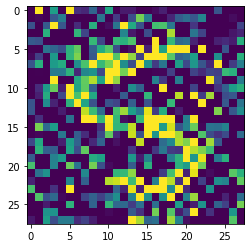

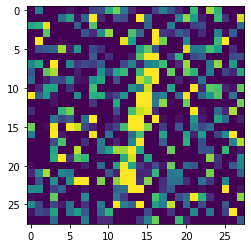

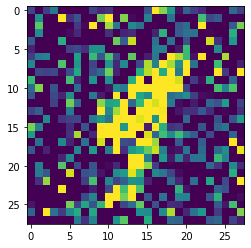

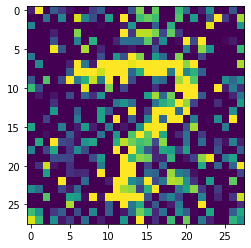

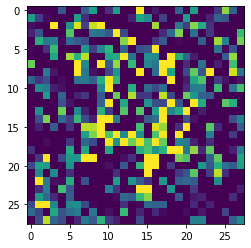

In [12]:
print_images(x_train_noisy, is_reshape=True)

# 3. Modeling

Pour modéliser plus facilement notre architecture nous allons nous baser sur une autre API de KERAS. Voic doc : https://keras.io/getting-started/functional-api-guide/. Vous devrez modéliser un encoder et un decoder. 

## 3.1 Encoder

L'encoder se compose de couches de [Convolution2D, MaxPooling2D]

In [13]:
#Construisez l'encoder en "stackant" des couches décrites ci dessus
input_img = Input(shape=(28,28,1))
e_conv1 = Convolution2D(kernel_size=(2,2), filters=16, strides=(1,1))(input_img)
e_maxPool1 = MaxPooling2D((2,2),border_mode='same')(e_conv1)

e_conv2 = Convolution2D(kernel_size=(2,2), filters=16, strides=(1,1))(e_maxPool1)
e_maxPool2 = MaxPooling2D((2,2),border_mode='same')(e_conv2)

encoded = e_maxPool2
print(encoded.shape)

(None, 7, 7, 16)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), padding="same")`
  import sys


## 3.2 Decoder

De la même manière que pour l'encoder, construisez le décodeur en impilant des couches. Ces couches se composent des deux éléments suivants : [Convolution2D, UpSampling2D]

In [14]:
d_conv1 = Convolution2D(1,3,3,activation='relu',border_mode='same')(encoded)
d_upSamp1 = UpSampling2D(size=(2,2), interpolation='nearest')(d_conv1)

d_conv2 = Convolution2D(1,2,2,activation='relu',border_mode='same')(d_upSamp1)
d_upSamp2 = UpSampling2D(size=(2,2), interpolation='nearest')(d_conv2)

decoded = d_upSamp2
#decoded = Convolution2D(1,3,3,activation='sigmoid',border_mode='same')(x)
#back to 28,28,1
print(decoded.shape)

(None, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (3, 3), activation="relu", padding="same")`
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (2, 2), activation="relu", padding="same")`
  after removing the cwd from sys.path.


## 3.3 Merge 
On combine alors l'encoder et le decoder, puis on définit une loss. Pour combiner le modèle basez vous sur Model()

In [38]:
# create the autoencoder by merging the encode and decode networks together
#inputs=[e_conv1, e_conv2], outputs=[d_conv1, d_conv2]
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
autoencoder.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        1040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 1)           145       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 1)         0  

# 4.0 Train

On entraîne le modèle.

In [39]:
# train
autoencoder.fit(x_train_noisy, x_train,
  nb_epoch=2,
  batch_size=256,
  shuffle=True,
  validation_data=(x_test_noisy, x_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 13s 222us/step - loss: 0.2406 - val_loss: 0.2175
Epoch 2/2
60000/60000 [==============================] - 13s 217us/step - loss: 0.2127 - val_loss: 0.2091


# 5.0 Use the model for denoying

In [40]:
decoded_imgs = autoencoder.predict(x_test_noisy)

# 6.0 Print the results

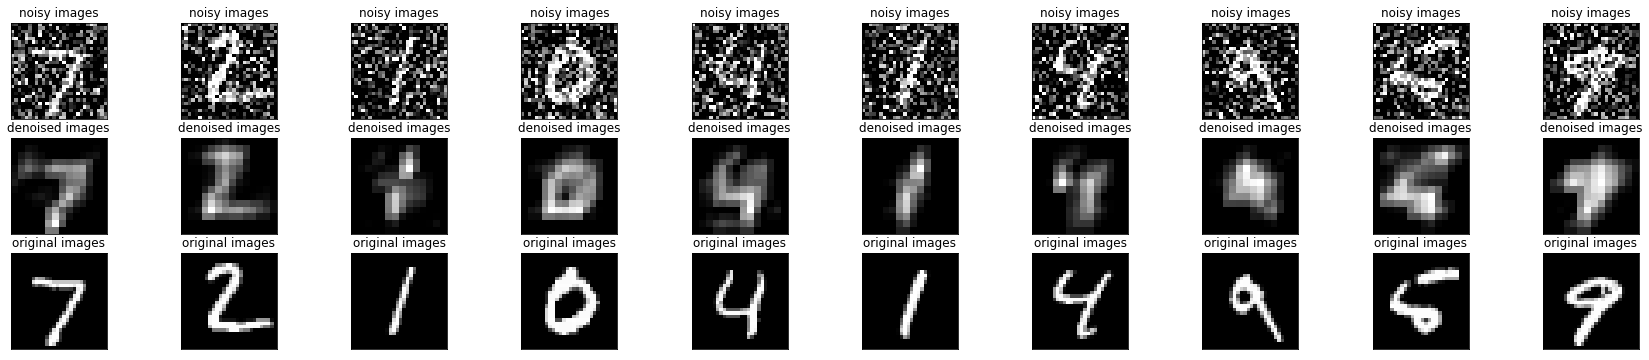

In [41]:
# display the images
n = 10
plt.figure(figsize=(30,6))
for i in range(n):
  # noisy images
  ax = plt.subplot(3,n,i+1)
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)    
  ax.set_title('noisy images')

  # denoised images
  ax = plt.subplot(3,n,i+1+n)
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_title('denoised images')

  # original images
  ax = plt.subplot(3,n,i+1+n*2)
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_title('original images')

plt.show()